In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('dataset/df.csv')
df.head()

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  

[5 rows x 21 columns]

In [ ]:
from dataset import BusTruckDataset
from utils import draw_boxes
from torchsummary import summary

from torchvision import transforms
import albumentations as A
import warnings
from torch.utils.data import DataLoader

warnings.filterwarnings('ignore')

# Preparing the Data

In [4]:
transform = A.Compose([
    A.Mosaic(p=0.7, grid_yx=(2, 2), target_size=(200, 200), cell_shape=(120, 120), center_range=(0.4, 0.6)),
    A.CLAHE(p=0.01),
    A.HorizontalFlip(p=0.5),
    A.MedianBlur(p=0.01), 
    A.Blur(p=0.01),  
    A.ToGray(p=0.01),  
    A.HueSaturationValue(p=0.01, hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20),
    A.RandomBrightnessContrast(p=0.01, brightness_limit=0.2, contrast_limit=0.2), 
    A.Resize(height=640, width=640, p=1.0),
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_visibility=0.3))

val_transform = A.Compose([
                        A.Resize(height=640, width=640, p=1.0),
                        ],
                           bbox_params=A.BboxParams(format='yolo', label_fields=['labels'], min_visibility=0.3))

predict_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

BusTruckDataset.Transform = predict_transform

Train Instances:  {'Bus': 9543, 'Truck': 9659}
Test Instances:  {'Bus': 2384, 'Truck': 2476}


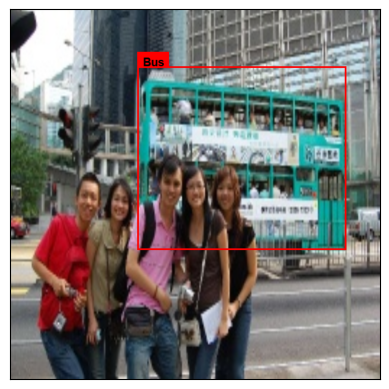

In [5]:
train_data = BusTruckDataset(df, index=[0, 0.8], img_dir='dataset/images/images',transform=transform)
test_data = BusTruckDataset(df, index=[0.8, 1], img_dir='dataset/images/images',transform=val_transform)

print('Train Instances: ', train_data.instances)
print('Test Instances: ', test_data.instances)

image, target = train_data[0]
labels = [train_data.decode_labels[label.item()] for label in target[..., 1]]

draw_boxes(image, target[...,2:],labels, normalized=True)

In [6]:
import os
os.cpu_count()  # Returns the number of available CPU cores (useful for setting num_workers in DataLoader)

16

In [7]:
train_loader = DataLoader(dataset=train_data,
                         drop_last=True,
                         batch_size=16, 
                         collate_fn=BusTruckDataset.collate_fn, 
                         pin_memory=True,
                         num_workers=10
                         )

test_loader = DataLoader(dataset=test_data, 
                         drop_last=True, 
                         batch_size=16, 
                         collate_fn=BusTruckDataset.collate_fn, 
                         pin_memory=True,
                         num_workers=10
                         )

# **Model Training**

In [8]:
import torch
from config import *
from model import YOLOV8
from loss import v8DetectionLoss
import importlib, engine
importlib.reload(engine)
from engine import ModelManager

device = 'cuda'
yolo_model = YOLOV8(yolo8vn).to(device)
loss_fn = v8DetectionLoss()
nc = 2
lrf = round(0.002 * 5 / (4 + nc), 6) 

optimizer = torch.optim.AdamW(yolo_model.parameters(), lr=lrf, weight_decay=0.0005) 

manager = ModelManager(yolo_model, optimizer, loss_fn)
manager.set_dataloaders(train_loader, test_loader)

epochs = 10
lf = lambda x: max(1 - x/epochs , 0) * (1.0 - lrf) + lrf  # linear
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
manager.set_lr_scheduler(scheduler)

In [9]:
s = summary(yolo_model, (3, 640, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 320, 320]             432
       BatchNorm2d-2         [-1, 16, 320, 320]              32
              SiLU-3         [-1, 16, 320, 320]               0
         ConvBlock-4         [-1, 16, 320, 320]               0
            Conv2d-5         [-1, 32, 160, 160]           4,608
       BatchNorm2d-6         [-1, 32, 160, 160]              64
              SiLU-7         [-1, 32, 160, 160]               0
         ConvBlock-8         [-1, 32, 160, 160]               0
            Conv2d-9         [-1, 32, 160, 160]           1,024
      BatchNorm2d-10         [-1, 32, 160, 160]              64
             SiLU-11         [-1, 32, 160, 160]               0
        ConvBlock-12         [-1, 32, 160, 160]               0
           Conv2d-13         [-1, 16, 160, 160]           2,304
      BatchNorm2d-14         [-1, 16, 1

In [10]:
manager.train(epochs, display_table=1)

In [11]:
manager.load_checkpoint('runs/88/best')

# **Model Evaluation**

In [12]:
draw_boxes_val_batch = manager.predict_val_batch()

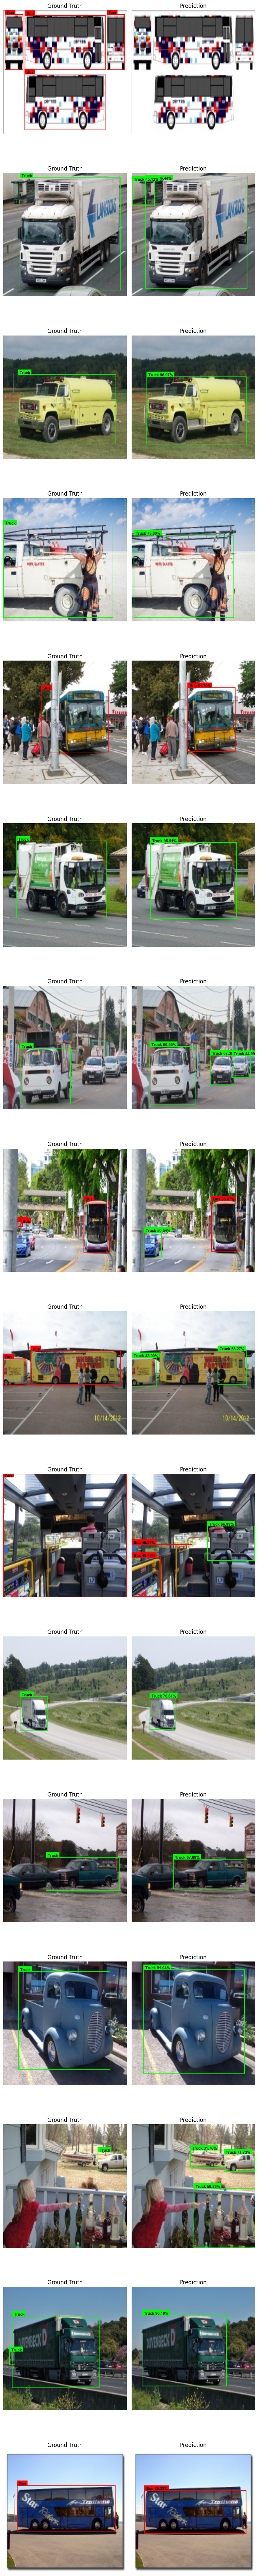

In [13]:
draw_boxes_val_batch() # call it again to draw the next batch

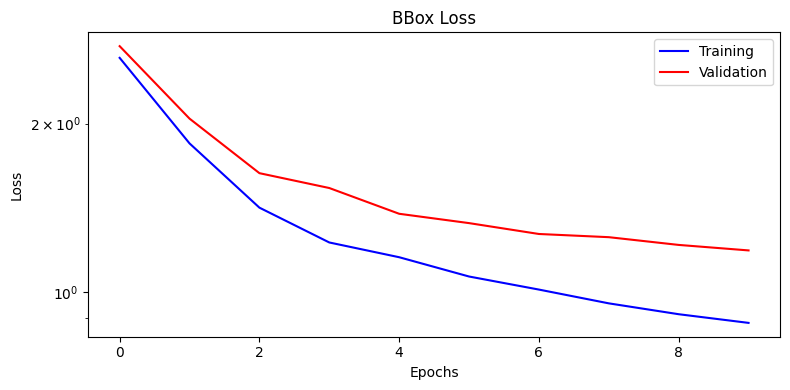

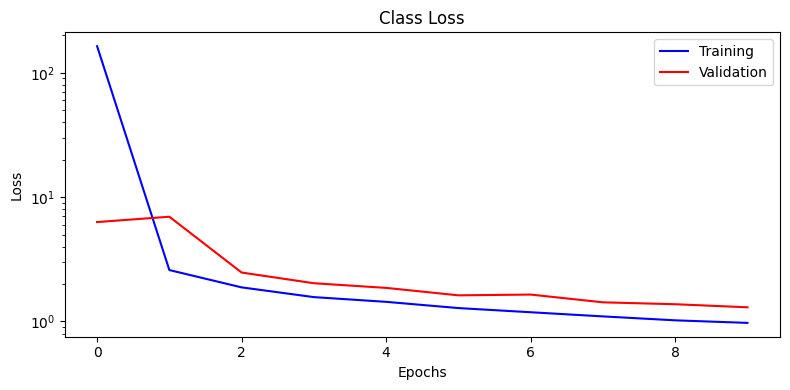

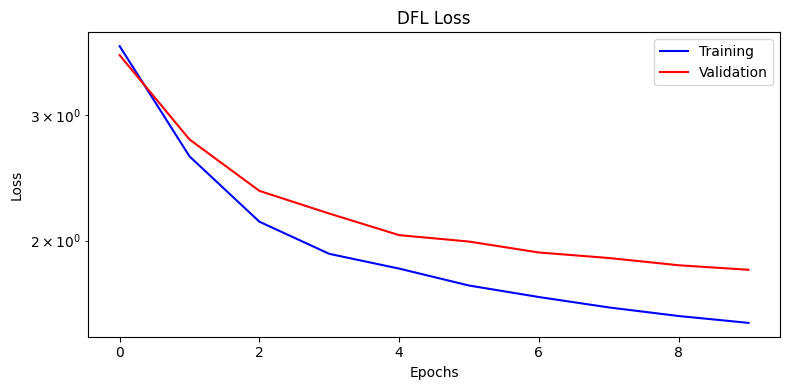

In [14]:
fig = manager.plot_losses()

# **Inference on New Images**

   * Load the best weights
   * Predict and visualize detections

In [15]:
manager.load_checkpoint('runs/88/best')

⏱️ Time taken: 0.2793 seconds


[tensor([[452.1534, 343.5512, 181.9067, 257.4263]], device='cuda:0'),
 ['Truck']]

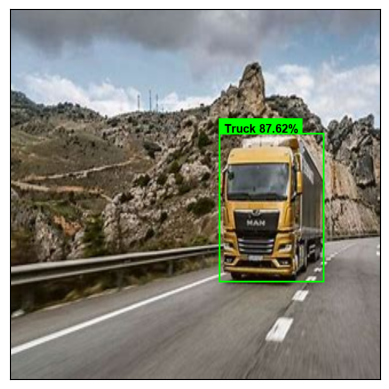

In [16]:
manager.predict('val_images/1.jpg', conf_thresh=0.3)

⏱️ Time taken: 0.1060 seconds


[tensor([[209.5505, 343.4002, 208.2586, 194.9641],
         [522.7546, 367.8735, 115.4812, 157.4305],
         [407.3036, 323.9438, 205.1343, 240.7257]], device='cuda:0'),
 ['Bus', 'Truck', 'Truck']]

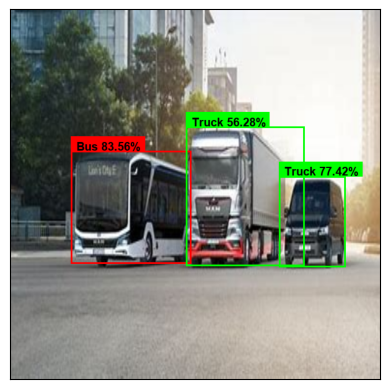

In [17]:
manager.predict('val_images/2.jpg', conf_thresh=0.3)

⏱️ Time taken: 0.1890 seconds


[tensor([[465.9329, 298.6621, 291.3599, 246.8784],
         [238.1603, 288.1366, 143.8080, 245.4814],
         [356.4819, 293.0204, 191.7070, 250.5442]], device='cuda:0'),
 ['Bus', 'Bus', 'Bus']]

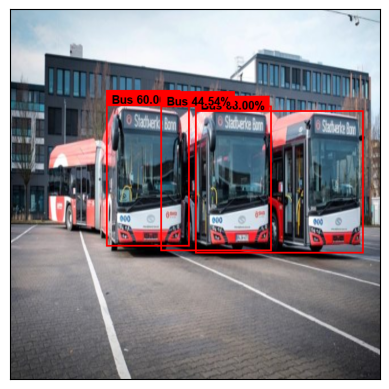

In [12]:
manager.predict('val_images/3.jpg', conf_thresh=0.3)